In [95]:
import numpy as np 
import pandas as pd 
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [96]:
X_list = []
labels = []

for dirname, _, filenames in os.walk('./data/training'):
    for filename in filenames:
        if dirname == './data/training\\Fried food':
            X_list.append(
                cv.cvtColor(
                    cv.imread(os.path.join(dirname, filename))
                    ,cv.COLOR_BGR2RGB)
            )
            labels.append('FriedFood')
        elif dirname == './data/training\\Meat':
            X_list.append(cv.cvtColor(
                    cv.imread(os.path.join(dirname, filename))
                    ,cv.COLOR_BGR2RGB)
            )
            labels.append('Meat')

X = np.asarray(X_list)

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [97]:
import ColorMoments as cm

df = pd.DataFrame()

meanR_list = []
varR_list = []
skewR_list = []
meanG_list = []
varG_list = []
skewG_list = []
meanB_list = []
varB_list = []
skewB_list = []

for i in range(len(X)):
    h = X[i].shape[0]
    w = X[i].shape[1]
    ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
    crop = X[i][ymin:ymax, xmin:xmax]
    resized = cv.resize(crop, (0,0), fx=0.5, fy=0.5)
    
    meanR, varR, skewR = cm.getColorMoment(crop[:,:,0]/255)
    meanG, varG, skewG = cm.getColorMoment(crop[:,:,1]/255)
    meanB, varB, skewB = cm.getColorMoment(crop[:,:,2]/255)
    
    meanR_list.append(meanR)
    varR_list.append(varR)
    skewR_list.append(skewR)
    meanG_list.append(meanG)
    varG_list.append(varG)
    skewG_list.append(skewG)
    meanB_list.append(meanB)
    varB_list.append(varB)
    skewB_list.append(skewB)

df['meanR'] = meanR_list
df['varR'] = varR_list
df['skewR'] = skewR_list
df['meanG'] = meanG_list
df['varG'] = varG_list
df['skewG'] = skewG_list
df['meanB'] = meanB_list
df['varB'] = varB_list
df['skewB'] = skewB_list

print(df)

        meanR      varR     skewR     meanG      varG     skewG     meanB  \
0    0.476121  0.158375 -0.136288  0.153131  0.083122  0.052147  0.051228   
1    0.744509  0.134182 -0.136444  0.421190  0.160822 -0.032004  0.124460   
2    0.598654  0.180841  0.075462  0.349525  0.187097  0.149022  0.180766   
3    0.543399  0.243265  0.185622  0.355875  0.256737  0.259721  0.224853   
4    0.431776  0.288479  0.094911  0.240741  0.195905  0.147508  0.120904   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.311795  0.317605  0.307726  0.379208  0.320332  0.288455  0.263959   
996  0.557956  0.169024 -0.155681  0.207986  0.089012  0.092137  0.031138   
997  0.730964  0.193817 -0.162832  0.460730  0.259972 -0.157646  0.346239   
998  0.502568  0.256428  0.217433  0.377095  0.294429  0.295665  0.211720   
999  0.496319  0.276482 -0.151642  0.316047  0.213813  0.136375  0.139559   

         varB     skewB  
0    0.039956  0.043234  
1    0.139556  0.165922

In [98]:
from skimage.feature import greycomatrix, greycoprops
def calc_glcm_all_agls(img, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    
    return feature

In [99]:
def get_glcm_channel(X,channel):
    ch = 0
    if channel == 'R':
        ch = 0
    elif channel == 'G':
        ch = 1
    elif channel == 'B':
        ch = 2
            
    gray_list = []
    for i in range(len(X)):
        gray = X[i][:,:,ch]

        h = gray.shape[0]
        w = gray.shape[1]
        ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
        crop = gray[ymin:ymax, xmin:xmax]

        resized = cv.resize(crop, (0,0), fx=0.5, fy=0.5)
        gray_list.append(crop)

    properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

    glcm_all_agls = []
    for img, label in zip(gray_list, labels): 
        glcm_all_agls.append(
                calc_glcm_all_agls(img, 
                                    props=properties)
                                )

    columns = []
    angles = ['0', '45', '90','135']
    for name in properties :
        for ang in angles:
            columns.append(name + "_" + ang +"_"+ channel)
    return pd.DataFrame(glcm_all_agls, columns = columns)
    # columns.append("label")

glcm_R = get_glcm_channel(X,'R')
glcm_G = get_glcm_channel(X,'G')
glcm_B = get_glcm_channel(X,'B')

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

new_df = pd.concat([df,glcm_R,glcm_G,glcm_B], axis=1)
X = new_df.iloc[:, :-1].values
# y = new_df.iloc[:, -1].values
y = np.asarray(labels)

# scaler = StandardScaler()
# scaled_X = scaler.fit_transform(X)

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

In [104]:
classifier = KNeighborsClassifier(n_neighbors=10, weights='distance')
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, weights='distance')

In [105]:
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[81 18]
 [26 75]]
              precision    recall  f1-score   support

   FriedFood       0.76      0.82      0.79        99
        Meat       0.81      0.74      0.77       101

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



In [13]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.train()

Using cache found in C:\Users\Acer/.cache\torch\hub\pytorch_vision_v0.6.0


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [14]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

def load_split_train_test(datadir, valid_size = .3):
    train_transforms = transforms.Compose([transforms.Resize((256,256)),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize((256,256)),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                      ])
    
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler)
    return trainloader, testloader


data_dir = "./data/training"
trainloader, testloader = load_split_train_test(data_dir, .1)

In [23]:
from torch import nn

for param in model.parameters():
    param.requires_grad = True

model.classifier[0] = nn.Dropout(p=0.5, inplace=False)
model.classifier[1] = nn.Linear(1280, 1000, bias = True)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
model.to(device)
counta = 0
countb = 0

450
450


In [24]:
epochs = 3
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
train_accuracy = 0
for epoch in range(epochs):
    for train_inputs, train_labels in trainloader:
        steps += 1
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
        optimizer.zero_grad()
        train_logps = model(train_inputs)
        train_loss = criterion(train_logps, train_labels)
        train_loss.backward()
        optimizer.step()
        running_loss += train_loss.item()
        
        train_ps = torch.exp(train_logps)
        train_top_p, train_top_class = train_ps.topk(1, dim=1)
        train_equals = train_top_class == train_labels.view(*train_top_class.shape)
        train_accuracy += torch.mean(train_equals.type(torch.FloatTensor)).item() 
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            test_losses.append(test_loss/len(testloader))     
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Train accuracy: {train_accuracy/print_every:.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            train_accuracy = 0
            model.train()

Epoch 1/3.. Train loss: 21.051.. Test loss: 0.695.. Train accuracy: 0.500.. Test accuracy: 0.500
Epoch 1/3.. Train loss: 8.841.. Test loss: 19.655.. Train accuracy: 0.600.. Test accuracy: 0.500
Epoch 1/3.. Train loss: 6.022.. Test loss: 19.884.. Train accuracy: 0.500.. Test accuracy: 0.500
Epoch 1/3.. Train loss: 9.944.. Test loss: 8.117.. Train accuracy: 0.600.. Test accuracy: 0.500
Epoch 1/3.. Train loss: 2.619.. Test loss: 4.692.. Train accuracy: 0.600.. Test accuracy: 0.550
Epoch 1/3.. Train loss: 1.498.. Test loss: 28.526.. Train accuracy: 0.500.. Test accuracy: 0.500
Epoch 1/3.. Train loss: 2.764.. Test loss: 5.318.. Train accuracy: 0.400.. Test accuracy: 0.500
Epoch 1/3.. Train loss: 1.829.. Test loss: 2.255.. Train accuracy: 0.400.. Test accuracy: 0.500
Epoch 1/3.. Train loss: 2.589.. Test loss: 2.281.. Train accuracy: 0.500.. Test accuracy: 0.500
Epoch 1/3.. Train loss: 1.040.. Test loss: 1.567.. Train accuracy: 0.500.. Test accuracy: 0.450
Epoch 1/3.. Train loss: 1.571.. Test

Epoch 1/3.. Train loss: 0.807.. Test loss: 1.145.. Train accuracy: 0.500.. Test accuracy: 0.570
Epoch 1/3.. Train loss: 1.187.. Test loss: 0.731.. Train accuracy: 0.400.. Test accuracy: 0.490
Epoch 1/3.. Train loss: 0.823.. Test loss: 0.762.. Train accuracy: 0.600.. Test accuracy: 0.500
Epoch 1/3.. Train loss: 0.881.. Test loss: 1.107.. Train accuracy: 0.600.. Test accuracy: 0.500
Epoch 2/3.. Train loss: 0.841.. Test loss: 0.808.. Train accuracy: 0.500.. Test accuracy: 0.500
Epoch 2/3.. Train loss: 0.863.. Test loss: 0.757.. Train accuracy: 0.500.. Test accuracy: 0.460
Epoch 2/3.. Train loss: 1.050.. Test loss: 0.753.. Train accuracy: 0.700.. Test accuracy: 0.540
Epoch 2/3.. Train loss: 1.036.. Test loss: 0.697.. Train accuracy: 0.300.. Test accuracy: 0.500
Epoch 2/3.. Train loss: 0.932.. Test loss: 0.717.. Train accuracy: 0.400.. Test accuracy: 0.500
Epoch 2/3.. Train loss: 0.777.. Test loss: 0.726.. Train accuracy: 0.300.. Test accuracy: 0.500
Epoch 2/3.. Train loss: 0.826.. Test los

Epoch 2/3.. Train loss: 0.837.. Test loss: 0.755.. Train accuracy: 0.800.. Test accuracy: 0.500
Epoch 2/3.. Train loss: 0.598.. Test loss: 0.758.. Train accuracy: 0.700.. Test accuracy: 0.490
Epoch 2/3.. Train loss: 0.614.. Test loss: 0.749.. Train accuracy: 0.600.. Test accuracy: 0.510
Epoch 2/3.. Train loss: 1.273.. Test loss: 1.011.. Train accuracy: 0.700.. Test accuracy: 0.460
Epoch 2/3.. Train loss: 1.450.. Test loss: 1.824.. Train accuracy: 0.500.. Test accuracy: 0.500
Epoch 2/3.. Train loss: 2.276.. Test loss: 0.874.. Train accuracy: 0.500.. Test accuracy: 0.430
Epoch 2/3.. Train loss: 0.870.. Test loss: 0.728.. Train accuracy: 0.500.. Test accuracy: 0.400
Epoch 2/3.. Train loss: 0.887.. Test loss: 0.934.. Train accuracy: 0.400.. Test accuracy: 0.440
Epoch 3/3.. Train loss: 0.920.. Test loss: 1.368.. Train accuracy: 0.700.. Test accuracy: 0.500
Epoch 3/3.. Train loss: 3.174.. Test loss: 2.955.. Train accuracy: 0.800.. Test accuracy: 0.500
Epoch 3/3.. Train loss: 2.564.. Test los

Epoch 3/3.. Train loss: 0.793.. Test loss: 0.741.. Train accuracy: 0.400.. Test accuracy: 0.510
Epoch 3/3.. Train loss: 0.650.. Test loss: 1.247.. Train accuracy: 0.700.. Test accuracy: 0.500
Epoch 3/3.. Train loss: 0.974.. Test loss: 0.799.. Train accuracy: 0.300.. Test accuracy: 0.420
Epoch 3/3.. Train loss: 0.808.. Test loss: 0.713.. Train accuracy: 0.200.. Test accuracy: 0.450
Epoch 3/3.. Train loss: 0.805.. Test loss: 0.862.. Train accuracy: 0.500.. Test accuracy: 0.500
Epoch 3/3.. Train loss: 0.637.. Test loss: 1.257.. Train accuracy: 0.600.. Test accuracy: 0.500
Epoch 3/3.. Train loss: 1.022.. Test loss: 0.682.. Train accuracy: 0.600.. Test accuracy: 0.540
Epoch 3/3.. Train loss: 0.915.. Test loss: 0.949.. Train accuracy: 0.500.. Test accuracy: 0.500
Epoch 3/3.. Train loss: 1.087.. Test loss: 0.888.. Train accuracy: 0.600.. Test accuracy: 0.500
Epoch 3/3.. Train loss: 1.458.. Test loss: 1.058.. Train accuracy: 0.500.. Test accuracy: 0.500
Epoch 3/3.. Train loss: 0.991.. Test los

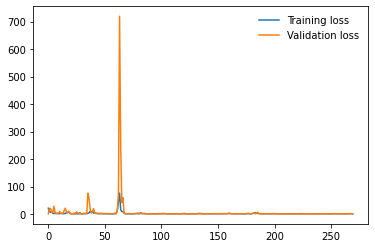

In [25]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [18]:
torch.save(model.state_dict(), './Model')

In [26]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [27]:
print(total_params)

3506874
